In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Redes neurais

In [109]:
class TanhRegressionNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TanhRegressionNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.tanh(x)
        x = self.output(x)
        return x

In [110]:
class ReLUClassificationNeuralNetwork():
    def __init__(self, input_size, hidden_size, output_size, dim):
        super(RegressionNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim = dim)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.softmax(x)
        return x

## Funções de treino

In [111]:
def trainRegressionNetwork(network, x_train, y_train, learning_rate = 0.001, momentum = 0.9, num_epochs = 250, batch_size = 32):

    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
    lossValues = np.zeros(num_epochs)
    lossFunction = nn.MSELoss()

    for epoch in range(num_epochs):

        indices = torch.randperm(x.shape[0])
        x_it = x_train[indices]
        y_it = y_train[indices]

        for i in range (0, x_it.shape[0], batch_size):
            inputs = x_it[i:i+batch_size]
            targets = y_it[i:i+batch_size]

            optimizer.zero_grad()

            output = network(inputs)
            loss = lossFunction(output, targets)

            loss.backward()
            optimizer.step()

        lossValues[epoch] = loss.item()
    
    return lossValues

In [112]:
def trainClassificationNetwork(network, learning_rate, x_train, y_train, momentum = 0.9, num_epochs = 250, batch_size = 32):

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    lossValues = np.zeros(num_epochs)
    lossFunction = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):

        indices = torch.randperm(x.shape[0])
        x_it = x_train[indices]
        y_it = y_train[indices]

        for i in range (0, x_it.shape[0], batch_size):
            inputs = x_it[i:i+batch_size]
            targets = y_it[i:i+batch_size]

            optimizer.zero_grad()

            output = network(inputs)
            loss = lossFunction(output, targets)

            loss.backward()
            optimizer.step()

        lossValues[epoch] = loss.item()
    
    return lossValues

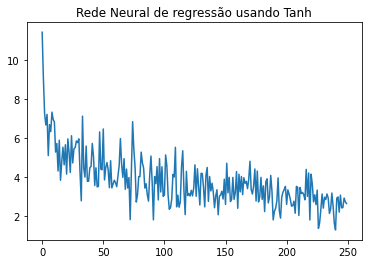

In [113]:
data = np.genfromtxt("vowel.csv", delimiter=',')

x = torch.Tensor(data[:, :10])
y = torch.Tensor(data[:, 10].reshape(-1, 1))

regressor = TanhRegressionNeuralNetwork(x.shape[1], 15, 1)
MSE = trainRegressionNetwork(regressor, x, y)

plt.title("Rede Neural de regressão usando Tanh")
plt.plot(np.arange(MSE.size), MSE)
plt.show()